In [2]:
import statsmodels.formula.api as smf
import scipy
from patsy.contrasts import Treatment, Sum
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
df = pd.read_csv("")

In [3]:
df = df.query("US == 'No'")

In [4]:
sum_contrast = Sum().code_without_intercept(['Bad','Good','Medium'])
treatment_contrast = Treatment(reference = "No").code_without_intercept(['No','Yes'])
lm_smf_res = smf.ols('Sales ~Income + Price +\
                C( ShelveLoc, sum_contrast) + C(Urban, treatment_contrast) +\
                C(Urban, treatment_contrast):Income',data = df ).fit()
lm_smf_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.577
Model:                            OLS   Adj. R-squared:                  0.558
Method:                 Least Squares   F-statistic:                     30.70
Date:                Sun, 16 Oct 2022   Prob (F-statistic):           4.81e-23
Time:                        13:51:48   Log-Likelihood:                -275.71
No. Observations:                 142   AIC:                             565.4
Df Residuals:                     135   BIC:                             586.1
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================================================
                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
Intercept                                     11.7571      0.908     12.950      0.000       9.962      13.553
C(ShelveLoc, sum_contrast)[S.Bad]             -1.9567      0.239     -8.179      0.000      -2.430      -1.484
C(ShelveLoc, sum_contrast)[S.Good]             2.2975      0.265      8.677      0.000       1.774       2.821
C(Urban, treatment_contrast)[T.Yes]            1.8878      0.769      2.454      0.015       0.367       3.409
Income                                         0.0267      0.009      2.977      0.003       0.009       0.044
C(Urban, treatment_contrast)[T.Yes]:Income    -0.0240      0.011     -2.162      0.032      -0.046      -0.002
Price                                         -0.0578      0.006    -10.069      0.000      -0.069      -0.046
==============================================================================
Omnibus:                        1.442   Durbin-Watson:                   2.294
Prob(Omnibus):                  0.486   Jarque-Bera (JB):                1.379
Skew:                           0.238   Prob(JB):                        0.502
Kurtosis:                       2.922   Cond. No.                     1.04e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.04e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## 1


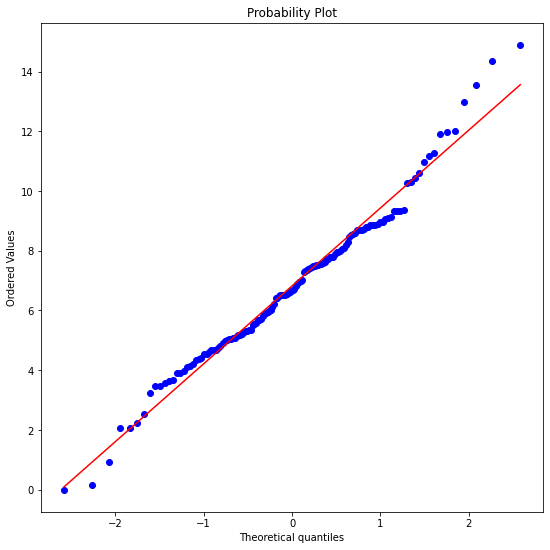

In [6]:
scipy.stats.probplot(df.Sales, dist="norm", plot=plt)
plt.rcParams['figure.figsize'] = [9, 9]
plt.show()

## 2 

In [15]:
def  get_estimate(x,y):
     a,b = np.polyfit(x, y, 1)
     out =  a*x + b
     return out

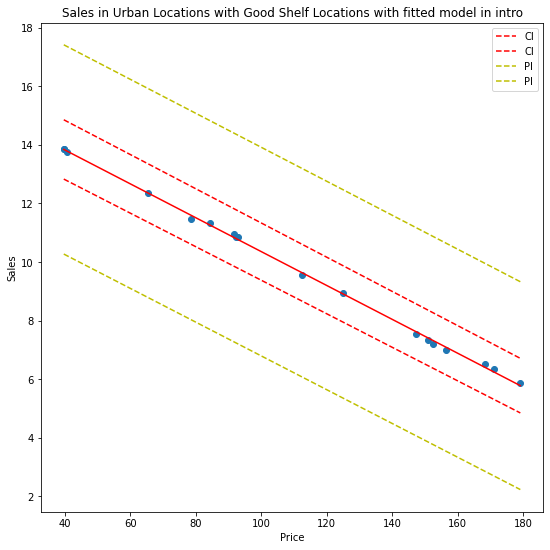

In [16]:
df_q2 = df.query("Urban == 'Yes'").query('ShelveLoc == "Good"')
df_q2["Price"] = np.random.uniform(24,185,len(df_q2["Price"]))
df_q2 = df_q2.sort_values("Price").drop("Sales",axis = 1)
predictions = lm_smf_res.get_prediction(df_q2)
predictions_sum = predictions.summary_frame(alpha=0.05)
plt.scatter( df_q2['Price'],predictions_sum["mean"],ls = '-')
plt.plot( df_q2['Price'],get_estimate(df_q2['Price'],predictions_sum["mean"]),ls = '-',c = "r")
plt.plot( df_q2['Price'],get_estimate(df_q2['Price'],predictions_sum["mean_ci_lower"]), ls ='--',c = "r",label="CI")
plt.plot(df_q2['Price'], get_estimate(df_q2['Price'],predictions_sum["mean_ci_upper"]),ls = '--',c = "r",label="CI")
plt.plot(df_q2['Price'], get_estimate(df_q2['Price'],predictions_sum["obs_ci_lower"]), ls ='--',c = "y",label="PI")
plt.plot(df_q2['Price'], get_estimate(df_q2['Price'],predictions_sum["obs_ci_upper"]),ls = '--',c = "y",label="PI")
plt.rcParams['figure.figsize'] = [9, 9]
plt.legend(loc="upper right")
plt.title('Sales in Urban Locations with Good Shelf Locations with fitted model in intro')
plt.xlabel('Price') 
plt.ylabel('Sales') 
plt.show()

## 3

In [226]:
len(df)

142

In [19]:
from sklearn.utils import resample
n_iterations = 2000
estimated_price_beta = []
for i in range(n_iterations):
    train = resample(df, replace=True, n_samples=len(df))
    estimated_price_beta.append( smf.ols('Sales ~Income + Price +\
                C( ShelveLoc, sum_contrast) + C(Urban, treatment_contrast) +\
                C(Urban, treatment_contrast):Income',data = train ).fit().params.Price)

Text(0, 0.5, 'Density')

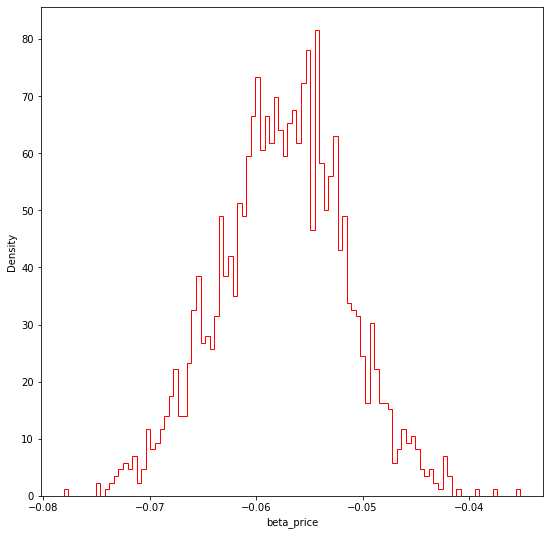

In [20]:
# Creating histogram
plt.hist(estimated_price_beta,bins = 100, color = "white", ec="red",density = True,histtype = "step" )
plt.xlabel('beta_price') 
plt.ylabel('Density') 

## 4 

In [22]:
from sklearn.utils import resample
n_iterations = 2000
estimated_beta = []
for i in range(n_iterations):
    train = resample(df, replace=True, n_samples=len(df))
    estimated_beta.append( smf.ols('Sales ~Income + Price +\
                C( ShelveLoc, sum_contrast) + C(Urban, treatment_contrast) +\
                C(Urban, treatment_contrast):Income',data = train ).fit().params)
result = pd.DataFrame(estimated_beta)
summary = result.head().T
summary.columns = ['Coef','std err', 't' , 'Lower', 'Upper'] 
summary["Coef"] = [np.mean(result[x]) for x in summary.index ]
summary["std err"] = [np.std(result[x]) for x in summary.index ]
summary["t"] = [np.mean(result[x])/np.std(result[x]) for x in summary.index ]
summary["Lower"] = [np.mean(result[x])-1.96*np.std(result[x])  for x in summary.index ]
summary["Upper"] = [np.mean(result[x])+1.96*np.std(result[x]) for x in summary.index ]
summary

,Coef,std err,t,Lower,Upper
Intercept,11.737490,0.993201,11.817835,9.790815,13.684165
"C(ShelveLoc, sum_contrast)[S.Bad]",-1.968143,0.234465,-8.394187,-2.427694,-1.508591
"C(ShelveLoc, sum_contrast)[S.Good]",2.307867,0.276175,8.356535,1.766564,2.849170
"C(Urban, treatment_contrast)[T.Yes]",1.876608,0.794317,2.362542,0.319746,3.433470
Income,0.027093,0.009803,2.763891,0.007880,0.046307
"C(Urban, treatment_contrast)[T.Yes]:Income",-0.024107,0.011416,-2.111600,-0.046483,-0.001731
Price,-0.057701,0.006043,-9.548781,-0.069545,-0.045857
